* KoBERT install

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-fy1ijkhk
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-fy1ijkhk
  Created wheel for kobert: filename=kobert-0.1.2-cp37-none-any.whl size=12718 sha256=8a9a5c77502bc1434b1f1732dc33ee2c7314bb3b5075f0dcf1ab583664f9ecaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-asdg3jyq/wheels/a2/b0/41/435ee4e918f91918be41529283c5ff86cd010f02e7525aecf3
Successfully built kobert


* Google Drive 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* https://github.com/School-is-hard/buddy_KoBERT.git 를 통해 git clone 가능
* 해당 페이지는 이미 구글 드라이브에 폴더가 형성되어 있으므로 넘어갔다.

* Package 설치

In [ ]:
!pip install -r /content/drive/'My Drive'/'Colab Notebooks'/buddy/requirements.txt 

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 7.9MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 1.2MB 16.8MB/s 
     |████████████████████████████████| 901kB 18.7MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 


* Path 추가

In [ ]:
import sys
sys.path.append('drive/My Drive/Colab Notebooks/')
sys.path.append('drive/My Drive/Colab Notebooks/buddy')

* import Package

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from tqdm import tqdm

import torch
from transformers import AdamW
from torch.utils.data import dataloader
from buddy.dataloader.wellness import WellnessTextClassificationDataset
from buddy.model.kobert import KoBERTforSequenceClassfication

In [ ]:
torch.cuda.is_available()

True

* 사전에 데이터 전처리 필요
  * preprocess 폴더의 training_data 속 함수를 이용해 준비

* Train 함수

In [ ]:
def train(device, epoch, model, optimizer, train_loader, save_step, save_ckpt_path, train_step = 0):
    losses = []
    train_start_index = train_step+1 if train_step != 0 else 0
    total_train_step = len(train_loader)
    model.train()

    with tqdm(total= total_train_step, desc=f"Train({epoch})") as pbar:
        pbar.update(train_step)
        for i, data in enumerate(train_loader, train_start_index):
          
            optimizer.zero_grad()
            outputs = model(**data)

            loss = outputs[0]

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss.item():.3f} ({np.mean(losses):.3f})")

            if i >= total_train_step or i % save_step == 0:
                torch.save({
                    'epoch': epoch,  # 현재 학습 epoch
                    'model_state_dict': model.state_dict(),  # 모델 저장
                    'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 저장
                    'loss': loss.item(),  # Loss 저장
                    'train_step': i,  # 현재 진행한 학습
                    'total_train_step': len(train_loader)  # 현재 epoch에 학습 할 총 train step
                }, save_ckpt_path)

    return np.mean(losses)

* Training

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

Train(49): 100%|██████████| 1179/1179 [03:45<00:00,  5.22it/s, Loss: 0.005 (0.024)]


,loss
0,5.582916
1,5.477502
2,5.407147
3,5.248615
4,5.012939
5,4.758283
6,4.487804
7,4.244143
8,4.001725
9,3.777458


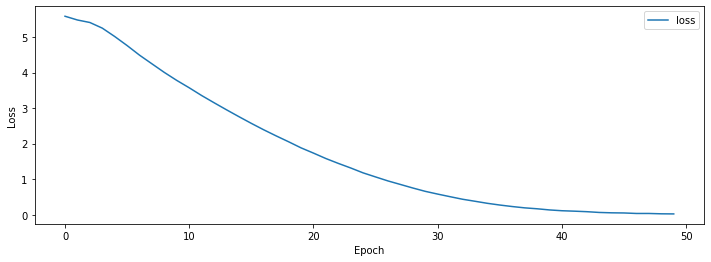

In [ ]:
root_path = "/content/drive/MyDrive/Colab Notebooks/buddy"
data_path = f"{root_path}/data/wellness_dialog_for_text_classification_train.txt"
checkpoint_path =f"{root_path}/checkpoint"
save_ckpt_path = f"{checkpoint_path}/kobert-wellnesee-text-classification.pth"

n_epoch = 50 #Num of Epoch
batch_size = 4 #배치 사이즈
ctx = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(ctx)
save_step = 100 #학습 저장 주기
learning_rate = 5e-6  #Learning Rate

#WellnessTextClassificationDataset Data Loader
dataset = WellnessTextClassificationDataset(file_path=data_path, device=device)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = KoBERTforSequenceClassfication()
model.to(device)

#Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

pre_epoch, pre_loss, train_step = 0, 0, 0
if os.path.isfile(save_ckpt_path):
    checkpoint = torch.load(save_ckpt_path, map_location=device)
    pre_epoch = checkpoint['epoch']
    train_step =  checkpoint['train_step']
    total_train_step =  checkpoint['total_train_step']

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"load pretrain from: {save_ckpt_path}, epoch={pre_epoch}")

losses = []
offset = pre_epoch
for step in range(n_epoch):
    epoch = step + offset
    loss = train(device, epoch, model, optimizer, train_loader, save_step, save_ckpt_path, train_step)
    losses.append(loss)

# data
data = {
    "loss": losses
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

* TEST
  * 해당 부분은 train이 아닌 example에 해당

In [ ]:
import torch
import torch.nn as nn
import random

from model.kobert import KoBERTforSequenceClassfication, kobert_input
from kobert_transformers import get_tokenizer

def load_wellness_answer():
  root_path = "/content/drive/MyDrive/Colab Notebooks/buddy"
  category_path = f"{root_path}/data/wellness_dialog_category.txt"
  answer_path = f"{root_path}/data/wellness_dialog_answer.txt"

  c_f = open(category_path,'r')
  a_f = open(answer_path,'r')

  category_lines = c_f.readlines()
  answer_lines = a_f.readlines()

  category = {}
  answer = {}
  for line_num, line_data in enumerate(category_lines):
    data = line_data.split('    ')
    category[data[1][:-1]]=data[0]

  for line_num, line_data in enumerate(answer_lines):
    data = line_data.split('    ')
    keys = answer.keys()
    if(data[0] in keys):
      answer[data[0]] += [data[1][:-1]]
    else:
      answer[data[0]] =[data[1][:-1]]

  return category, answer

if __name__ == "__main__":
  root_path = "/content/drive/MyDrive/Colab Notebooks/buddy"
  checkpoint_path =f"{root_path}/checkpoint"
  save_ckpt_path = f"{checkpoint_path}/kobert-wellnesee-text-classification.pth"

  #답변과 카테고리 불러오기
  category, answer = load_wellness_answer()

  ctx = "cuda" if torch.cuda.is_available() else "cpu"
  device = torch.device(ctx)

  # 저장한 Checkpoint 불러오기
  checkpoint = torch.load(save_ckpt_path, map_location=device)

  model = KoBERTforSequenceClassfication()
  model.load_state_dict(checkpoint['model_state_dict'])

  model.to(ctx)
  model.eval()

  tokenizer = get_tokenizer()

  while 1:
    sent = input('\nQuestion: ') # '요즘 기분이 우울한 느낌이에요'
    data = kobert_input(tokenizer, sent, device, 512)

    if '종료' in sent:
      break

    output = model(**data)

    logit = output[0]
    softmax_logit = torch.softmax(logit,dim=-1)
    softmax_logit = softmax_logit.squeeze()

    max_index = torch.argmax(softmax_logit).item()
    max_index_value = softmax_logit[torch.argmax(softmax_logit)].item()

    answer_list = answer[category[str(max_index)]]
    answer_len= len(answer_list)-1
    answer_index = random.randint(0,answer_len)
    print(f'Answer: {answer_list[answer_index]}, index: {max_index}, softmax_value: {max_index_value}')
    print('-'*50)


Question: 요즘 우울한 기분이에요.
Answer: 우울함은 저절로 없어지기도 하지만 그렇지 않을 때도 있어요. 그럴 때는 전문가에게 도움을 요청하는 것도 좋은 방법이에요., index: 59, softmax_value: 0.9988963603973389
--------------------------------------------------

Question: 가슴이 답답해서 터질 것만 같아요.
Answer: 신체적인 문제는 없나요? 아니면 혹시 힘든 일이 있으신가요?, index: 264, softmax_value: 0.996057391166687
--------------------------------------------------

Question: 종료해주세요.
